## Question 1a

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

class Net(nn.Module):
    def __init__(self, h=5):
        super(Net, self).__init__()
        self.hl = nn.Linear(5, h)
        self.ol = nn.Linear(h, 1)
        
    def forward(self, x):
        x = F.relu(self.hl(x))
        x = F.sigmoid(self.ol(x))
        return x
    
class Net2(nn.Module):
    def __init__(self, h1, h2):
        super(Net2, self).__init__()
        self.h1 = nn.Linear(5, h1)
        self.h2 = nn.Linear(h1, h2)
        self.ol = nn.Linear(h2, 1)
        
    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.sigmoid(self.ol(x))
        return x
    
class OccDataset(Dataset):
    train_data = pd.read_csv('train_data.txt').drop(['date'], axis=1)
    test_data = pd.read_csv('test_data.txt').drop(['date'], axis=1)
    train_dataset = torch.Tensor(train_data.as_matrix()).type(torch.FloatTensor)
    test_dataset = torch.Tensor(test_data.as_matrix()).type(torch.FloatTensor)
    train_input = train_dataset[:,:-1]
    train_output = train_dataset[:,-1].view((-1,1))
    test_input = test_dataset[:,:-1]
    test_output = test_dataset[:,-1].view((-1,1))
    train_mean = torch.mean(train_input, dim=0)
    train_std = torch.std(train_input, dim=0)
    train_input = (train_input - train_mean)/train_std
    test_input = (test_input - train_mean)/train_std
    
    def __init__(self, train=True):
        if train:
            self.dataset = OccDataset.train_input
            self.target = OccDataset.train_output
        else:
            self.dataset = OccDataset.test_input
            self.target = OccDataset.test_output
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx], self.target[idx]
    

def run(Net=Net, verbose=False, netparams={}, batch_size=100, test_batch_size=10, epochs=10, lr=0.01, momentum=0.5, error_fn=F.binary_cross_entropy):
    torch.manual_seed(1)
    train_loader = DataLoader(OccDataset(train=True), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(OccDataset(train=False), batch_size=test_batch_size, shuffle=True)
    model = Net(**netparams)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    def train(epoch):
        model.train()
        for data, target in train_loader:
            data, target = Variable(data), Variable(target.type(torch.FloatTensor))
            optimizer.zero_grad()
            output = model(data)
            loss = error_fn(output, target)
            loss.backward()
            optimizer.step()

    def test(epoch):
        model.eval()
        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            data, target = Variable(data, volatile=True), Variable(target.type(torch.FloatTensor))
            output = model(data)
            train_loss += error_fn(output, target, size_average=False).data[0]
            train_correct += target.data.eq((output.data >= 0.5).type(torch.FloatTensor).view((-1,1))).long().sum()

        train_loss /= len(train_loader.dataset)
        test_loss = 0
        test_correct = 0
        for data, target in test_loader:
            data, target = Variable(data, volatile=True), Variable(target.type(torch.FloatTensor))
            output = model(data)
            test_loss += error_fn(output, target, size_average=False).data[0]
            test_correct += target.data.eq((output.data >= 0.5).type(torch.FloatTensor).view((-1,1))).long().sum()

        test_loss /= len(test_loader.dataset)
        if verbose:
            print('|{:.0f}|{:.4f}|{:.4f}|{:.2f}|{:.2f}|'.format(epoch, train_loss, test_loss,
                100. * train_correct/len(train_loader.dataset),
                100. * test_correct/len(test_loader.dataset)))
        return train_loss, 100. * train_correct/len(train_loader.dataset), test_loss, 100. * test_correct/len(test_loader.dataset)

    if verbose:
        print('|Train Average Loss|Test Average Loss|Train Accuracy|Test Accuracy|')
        print('|---|---|---|---|')
    train_losses = np.empty((epochs))
    train_accuracies = np.empty((epochs))
    test_losses = np.empty((epochs))
    test_accuracies = np.empty((epochs))
    for epoch in range(1, epochs + 1):
        train(epoch)
        train_losses[epoch-1], train_accuracies[epoch-1], test_losses[epoch-1], test_accuracies[epoch-1] = test(epoch)
    
    return train_losses, train_accuracies, test_losses, test_accuracies

In [2]:
_,_,_,_ = run(epochs=50, lr=0.01, batch_size=len(OccDataset.train_dataset),verbose=True)

|Train Average Loss|Test Average Loss|Train Accuracy|Test Accuracy|
|---|---|---|---|
|1|0.5799|0.6100|86.71|88.43|
|2|0.5773|0.6084|86.87|88.55|
|3|0.5742|0.6065|87.13|88.70|
|4|0.5710|0.6045|87.25|88.89|
|5|0.5677|0.6025|87.47|89.04|
|6|0.5644|0.6005|87.62|89.20|
|7|0.5611|0.5985|87.82|89.69|
|8|0.5578|0.5964|87.93|89.84|
|9|0.5545|0.5944|88.08|89.93|
|10|0.5513|0.5925|88.16|90.11|
|11|0.5481|0.5905|88.27|90.22|
|12|0.5450|0.5885|88.41|90.38|
|13|0.5418|0.5866|88.57|90.55|
|14|0.5387|0.5847|88.64|90.73|
|15|0.5356|0.5828|88.81|90.94|
|16|0.5325|0.5809|89.09|91.11|
|17|0.5295|0.5790|89.29|91.24|
|18|0.5265|0.5771|89.40|91.44|
|19|0.5235|0.5753|89.43|91.54|
|20|0.5206|0.5735|89.55|91.60|
|21|0.5177|0.5717|89.55|91.61|
|22|0.5148|0.5699|89.57|91.68|
|23|0.5120|0.5681|89.62|91.79|
|24|0.5092|0.5663|89.71|91.95|
|25|0.5064|0.5645|89.84|92.09|
|26|0.5037|0.5628|89.97|92.26|
|27|0.5009|0.5611|90.05|92.47|
|28|0.4982|0.5594|90.21|92.63|
|29|0.4956|0.5577|90.47|92.73|
|30|0.4929|0.5560|90.72|

## Question1b

Base Run

In [3]:
def base_train_run(error_fn=F.binary_cross_entropy):
    np.random.seed(1)
    pred = np.empty(len(OccDataset.train_input))
    for x in range(len(pred)):
        s = (np.random.randint(0,2)+np.random.randint(0,2)+np.random.randint(0,2)
            +np.random.randint(0,2)+np.random.randint(0,2))
        if s >= 3:
            pred[x] = 1
        else:
            pred[x] = 0
    pred = torch.Tensor(pred).type(torch.FloatTensor)
    target = OccDataset.train_output
    correct = target.eq((pred >= 0.5).type(torch.FloatTensor).view((-1,1))).long()
    correct = correct.sum()
    print('Baseline Train Accuracy: ', 100. * correct/len(pred))
    print('Baseline Train Error: ', error_fn(Variable(pred.type(torch.FloatTensor).view((-1,1))), Variable(target.view((-1,1)))).data[0])

def base_test_run(error_fn=F.binary_cross_entropy):
    np.random.seed(1)
    pred = np.empty(len(OccDataset.test_input))
    for x in range(len(pred)):
        s = (np.random.randint(0,2)+np.random.randint(0,2)+np.random.randint(0,2)
            +np.random.randint(0,2)+np.random.randint(0,2))
        if s >= 3:
            pred[x] = 1
        else:
            pred[x] = 0
    pred = torch.Tensor(pred).type(torch.FloatTensor)
    target = OccDataset.test_output
    correct = target.eq((pred >= 0.5).type(torch.FloatTensor).view((-1,1))).long().sum()
    print('Baseline Test Accuracy: ', 100. * correct/len(pred))
    print('Baseline Test Error: ', error_fn(Variable(pred.type(torch.FloatTensor).view((-1,1))), Variable(target.view((-1,1)))).data[0])

base_train_run()
base_test_run()

Baseline Train Accuracy:  50.15350607884072
Baseline Train Error:  13.773707389831543
Baseline Test Accuracy:  49.82567678424938
Baseline Test Error:  13.864221572875977


## Question 1c

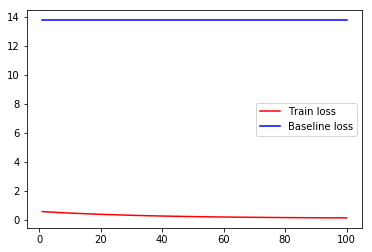

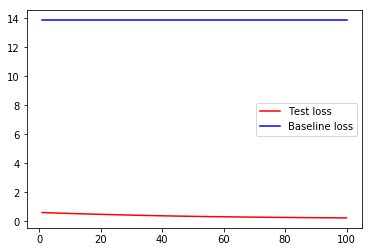

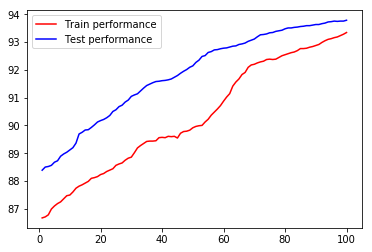

Train Performance:  93.3439764214663
Test Performance:  93.78589007383101


In [31]:
train_loss, _, test_loss, _ = run(lr=0.0005, epochs=100, batch_size=100, netparams={'h':5})
epochs = []
base_train_loss = []
base_test_loss = []
for i in range(100):
    epochs.append(i+1)
    base_train_loss.append(13.773707389831543)
    base_test_loss.append(13.864221572875977)
plt.plot(epochs,train_loss,'r-',label="Train loss")
plt.plot(epochs,base_train_loss,'b-',label="Baseline loss")
plt.legend()
plt.show()
plt.plot(epochs,test_loss,'r-',label="Test loss")
plt.plot(epochs,base_test_loss,'b-',label="Baseline loss")
plt.legend()
plt.show()

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

## Report

### Using Binary Cross Etropy Loss with SGD

* Learing rate used: 0.0005
* Train performace: 93.34%
* Test performace: 93.78%
* Clearly in both the graphs obtained losses are lower than the baseline losses.

## Question 1d

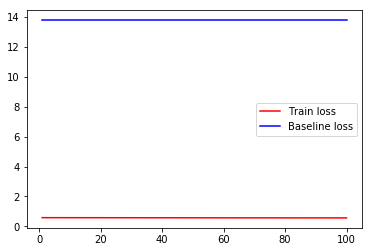

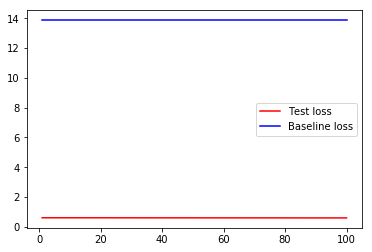

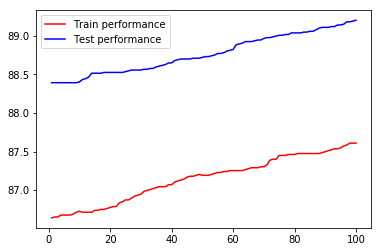

Train Performance:  87.60898931597691
Test Performance:  89.20221493027071


In [32]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.0005, epochs=100, batch_size=len(OccDataset.train_dataset), netparams={'h':5})
epochs = []
base_train_loss = []
base_test_loss = []
for i in range(100):
    epochs.append(i+1)
    base_train_loss.append(13.773707389831543)
    base_test_loss.append(13.864221572875977)
plt.plot(epochs,train_loss,'r-',label="Train loss")
plt.plot(epochs,base_train_loss,'b-',label="Baseline loss")
plt.legend()
plt.show()
plt.plot(epochs,test_loss,'r-',label="Test loss")
plt.plot(epochs,base_test_loss,'b-',label="Baseline loss")
plt.legend()
plt.show()

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

## Report

### Using Binary Cross Etropy Loss with batch gradient descent

* Learing rate used: 0.0005
* Train performace: 87.61%
* Test performace: 89.20%
* Clearly in both the graphs obtained losses are lower than the baseline losses.

## Question 1e

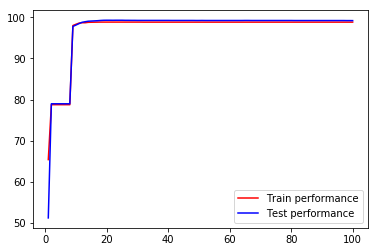

Train Performance:  98.82107331450325
Test Performance:  99.18990976210009


In [6]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, netparams={'h':1})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

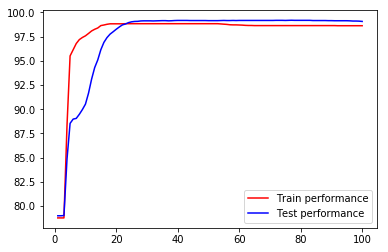

Train Performance:  98.62458553358714
Test Performance:  99.06685808039377


In [7]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, netparams={'h':2})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

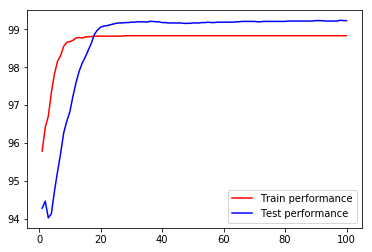

Train Performance:  98.83335380081051
Test Performance:  99.23092698933552


In [8]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, netparams={'h':5})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

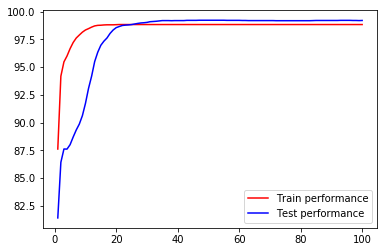

Train Performance:  98.83335380081051
Test Performance:  99.20016406890895


In [9]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, netparams={'h':10})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

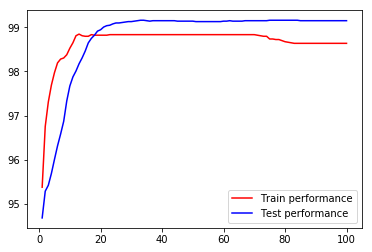

Train Performance:  98.63686601989438
Test Performance:  99.14889253486464


In [10]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, netparams={'h':20})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

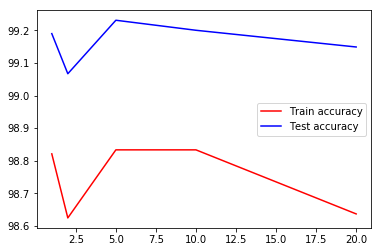

In [33]:
hidden_units = [1,2,5,10,20]
train_accuracies = [98.82107331450325,98.62458553358714,98.83335380081051,98.83335380081051,98.63686601989438]
test_accuracies = [99.18990976210009,99.06685808039377,99.23092698933552,99.20016406890895,99.14889253486464]
plt.plot(hidden_units,train_accuracies,'r-',label="Train accuracy")
plt.plot(hidden_units,test_accuracies,'b-',label="Test accuracy")
plt.legend()
plt.show()

## Report

* No general trend is observed in the above graph.
* All the accuracies are almost similar.

## Question 1f

In [38]:
base_train_run(F.mse_loss)
base_test_run(F.mse_loss)

Baseline Train Accuracy:  50.15350607884072
Baseline Train Error:  0.4984649419784546
Baseline Test Accuracy:  49.82567678424938
Baseline Test Error:  0.5017432570457458


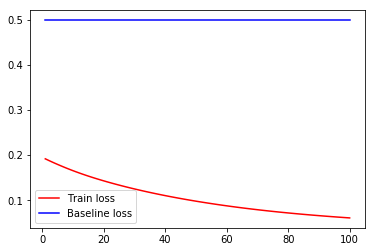

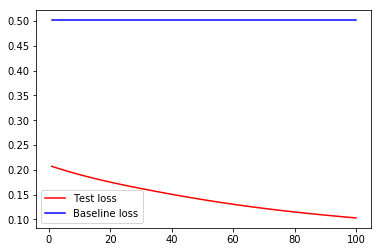

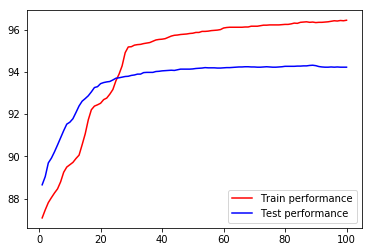

Train Performance:  96.43865897089525
Test Performance:  94.21657095980312


In [39]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.0005, epochs=100, batch_size=100, netparams={'h':5}, error_fn=F.mse_loss)
epochs = []
base_train_loss = []
base_test_loss = []
for i in range(100):
    epochs.append(i+1)
    base_train_loss.append(0.4984649419784546)
    base_test_loss.append(0.5017432570457458)
plt.plot(epochs,train_loss,'r-',label="Train loss")
plt.plot(epochs,base_train_loss,'b-',label="Baseline loss")
plt.legend()
plt.show()
plt.plot(epochs,test_loss,'r-',label="Test loss")
plt.plot(epochs,base_test_loss,'b-',label="Baseline loss")
plt.legend()
plt.show()

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

## Report

### Using MSE Loss with SGD

* Learing rate used: 0.0005
* Train performace: 96.44%
* Test performace: 94.22%
* Clearly in both the graphs obtained losses are lower than the baseline losses.

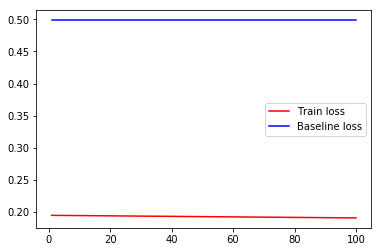

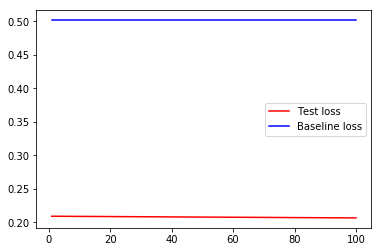

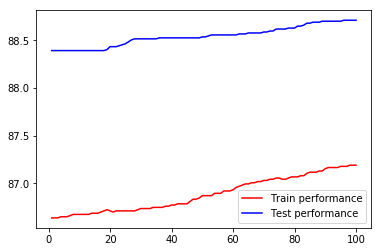

Train Performance:  87.19145278153015
Test Performance:  88.71000820344544


In [40]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.0005, epochs=100, batch_size=len(OccDataset.train_dataset), netparams={'h':5}, error_fn=F.mse_loss)
epochs = []
base_train_loss = []
base_test_loss = []
for i in range(100):
    epochs.append(i+1)
    base_train_loss.append(0.4984649419784546)
    base_test_loss.append(0.5017432570457458)
plt.plot(epochs,train_loss,'r-',label="Train loss")
plt.plot(epochs,base_train_loss,'b-',label="Baseline loss")
plt.legend()
plt.show()
plt.plot(epochs,test_loss,'r-',label="Test loss")
plt.plot(epochs,base_test_loss,'b-',label="Baseline loss")
plt.legend()
plt.show()

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

## Report

### Using MSE Loss with batch gradient descent

* Learing rate used: 0.0005
* Train performace: 87.19%
* Test performace: 89.71%
* Clearly in both the graphs obtained losses are lower than the baseline losses.

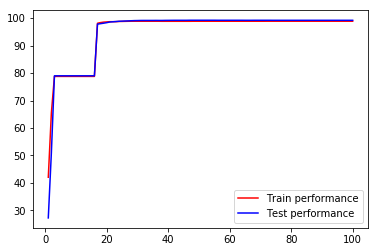

Train Performance:  98.84563428711778
Test Performance:  99.17965545529123


In [13]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, error_fn=F.mse_loss, netparams={'h':1})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

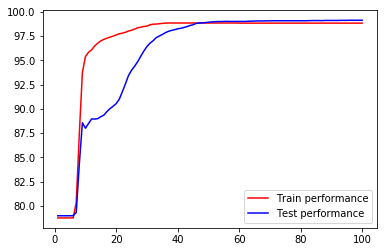

Train Performance:  98.82107331450325
Test Performance:  99.11812961443806


In [14]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, error_fn=F.mse_loss, netparams={'h':2})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

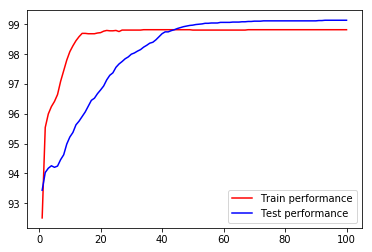

Train Performance:  98.82107331450325
Test Performance:  99.13863822805578


In [15]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, error_fn=F.mse_loss, netparams={'h':5})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

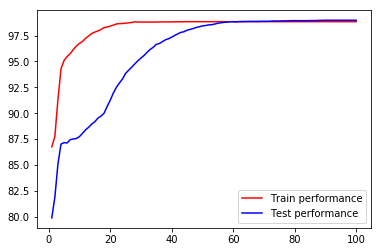

Train Performance:  98.84563428711778
Test Performance:  98.98482362592289


In [16]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, error_fn=F.mse_loss, netparams={'h':10})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

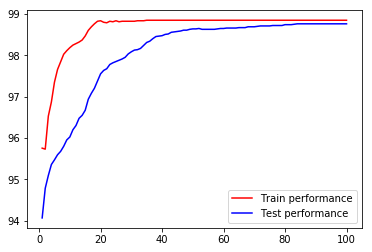

Train Performance:  98.84563428711778
Test Performance:  98.75922887612798


In [17]:
train_loss, train_accuracies, test_loss, test_accuracies = run(lr=0.01, epochs=100, batch_size=100, error_fn=F.mse_loss, netparams={'h':20})
epochs = []
base_loss = []
for i in range(100):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

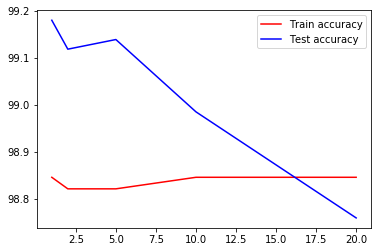

In [37]:
hidden_units = [1,2,5,10,20]
train_accuracies = [98.84563428711778,98.82107331450325,98.82107331450325,98.84563428711778,98.84563428711778]
test_accuracies = [99.17965545529123,99.11812961443806,99.13863822805578,98.98482362592289,98.75922887612798]
plt.plot(hidden_units,train_accuracies,'r-',label="Train accuracy")
plt.plot(hidden_units,test_accuracies,'b-',label="Test accuracy")
plt.legend()
plt.show()

## Report

* The train accuracy does not change much, but the test accuracy decreases with increase in hidden units.

## Question 1g

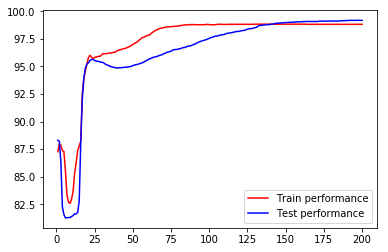

Train Performance:  98.82107331450325
Test Performance:  99.17965545529123


In [18]:
train_loss, train_accuracies, test_loss, test_accuracies = run(Net=Net2,netparams={'h1':5,'h2':2},lr=0.001, epochs=200, batch_size=100)
epochs = []
base_loss = []
for i in range(200):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

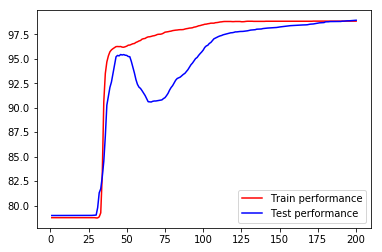

Train Performance:  98.83335380081051
Test Performance:  98.92329778506974


In [19]:
train_loss, train_accuracies, test_loss, test_accuracies = run(Net=Net2,netparams={'h1':10,'h2':20},lr=0.001, epochs=200, batch_size=100)
epochs = []
base_loss = []
for i in range(200):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

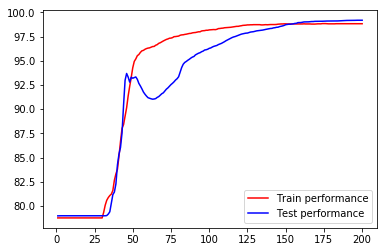

Train Performance:  98.82107331450325
Test Performance:  99.17965545529123


In [20]:
train_loss, train_accuracies, test_loss, test_accuracies = run(Net=Net2,netparams={'h1':10,'h2':5},lr=0.001, epochs=200, batch_size=100)
epochs = []
base_loss = []
for i in range(200):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

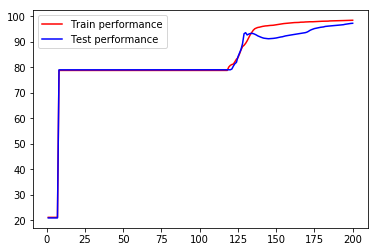

Train Performance:  98.41581726636375
Test Performance:  97.22108285479902


In [21]:
train_loss, train_accuracies, test_loss, test_accuracies = run(Net=Net2,netparams={'h1':10,'h2':2},lr=0.001, epochs=200, batch_size=100)
epochs = []
base_loss = []
for i in range(200):
    epochs.append(i+1)
    base_loss.append(13.773707389831543)

plt.plot(epochs,train_accuracies,'r-',label="Train performance")
plt.plot(epochs,test_accuracies,'b-',label="Test performance")
plt.legend()
plt.show()
print('Train Performance: ', train_accuracies[-1])
print('Test Performance: ', test_accuracies[-1])

## Report

* The train and test performances for different architectures are given below:

|Architecture|Train Performance|Test Performance|
|---|---|---|
|5-5-2-1|98.82|99.17|
|5-10-20-1|98.83|98.92|
|5-10-5-1|98.82|99.17|
|5-10-2-1|98.41|97.22|

* Among all the architectures that I have tried, 5-10-5-1 and 5-5-2-1 perform comaprable with that of single hidden layer network.
* For these two hidden layer networks to run, I changed the number of epochs to 200 so that to attain good accuracy.